# Plotting of reference and projected PCA scores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

Helper function to extract a list of variant names from pvar files

In [10]:
def read_vars_pvar(pvar_fn):
    """
    Read a pvar file and return list of variant names (3rd column)
    Parameters:
        pvar_fn: str
            Path to pvar file
    Returns:
        list[str]
            List of variant names
    """
    with open(pvar_fn, "r") as fh:
        var_list = [line.split()[2] for line in fh if not line[0] == "#"]
        
    return var_list[1:]

Define paths to the following required files:
 * reference sample eigenvectors
 * reference value eigenvalues, for standardization of scores
 * reference psam file that contains sample metadata
 * projection for assay file

In [12]:
reference_pcs = "../pcs/all_hg38.eigenvec"
reference_val = "../pcs/all_hg38.eigenval"
reference_psam = "../workpath/all_hg38.psam"
assay_pcs = "../assay_data/NBBR3377.sscore"

Load all the files

In [13]:
reference_df = pd.read_csv(reference_pcs, sep = '\t')
reference_psam = pd.read_csv(reference_psam, sep = '\t')
reference_val = np.loadtxt(reference_val)
assay_df = pd.read_csv(assay_pcs, sep = '\t')

Load the pvar files to do some comparisons on the variants

In [18]:
assay_pvar = Path("../assay_data/").glob("*pvar")
ref_pvar = "../workpath/pgen_prune.pvar"

assay_var = set([read_vars_pvar(fn) for fn in assay_pvar][0]) ### List comp form to support future analysis, subset to facilitate current one
ref_var = set(read_vars_pvar(ref_pvar))

### Obtain quotients of unique variants in each file

Assay unique

In [21]:
len(assay_var - ref_var) / len(assay_var)

0.7604868040903581

Reference unique

In [22]:
len(ref_var - assay_var) / len(ref_var)

0.9781898083840687

In [25]:
common_vars = ref_var & assay_var ### Intersect
len(common_vars)

1101594

### Prepare data for plot

Merge the principle components with the metadata from the psam file

In [14]:
reference_df = reference_df.merge(reference_psam, how = "inner", on = "#IID")
reference_df['SuperPop'] = reference_df['SuperPop'].astype("string")

Create a dictionary of a metadata column that allows for different colors 

In [15]:
pop_uniq = list(set(reference_df['SuperPop']))
cm_dic = {e: pop_uniq.index(e) for e in pop_uniq}

Plot the reference samples and assay sample. Note that assay coordinates must be divided by $\sqrt{\lambda_n}$

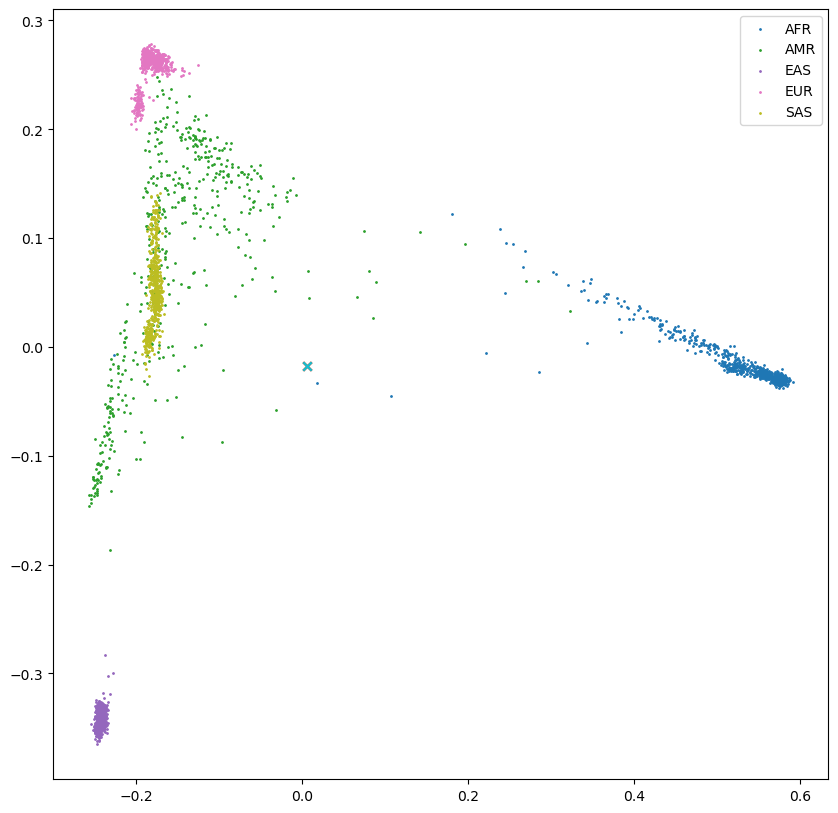

In [16]:
eigenval_sqrt = np.sqrt(reference_val)

fig, ax = plt.subplots(figsize = (10, 10))
for ix, df in reference_df.groupby("SuperPop"):
    ax.scatter(df['PC1'] * eigenval_sqrt[0], df['PC2'] * eigenval_sqrt[1], s = 1, label = ix)
    ax.scatter(assay_df['PC1_AVG'] / eigenval_sqrt[0], assay_df['PC2_AVG'] / eigenval_sqrt[1], marker = 'x')
    
ax.legend()